## pycaret을 활용한 회귀모델 개발

- 개발 목적 : 

  Medical Cost Personal Datasets에서 수집한 데이터 세트(연령, 성별, BMI 등)를 기반으로 건강보험에서 청구하는 개인 의료비(charges)을 예측하기 위한 회귀모델을 구현한다. 

- 종양 예측 및 분류의 필요성:

  의료비 예측 모델을 구현함으로써 보험료 산정을 보조하는 도구로 활용할 수 있다.  
  
- 목표: 
  - 데이터를 탐색하고, 전처리한다. 
  - pycaret을 통해 다양한 회귀모델을 구현한다.
  - 모델 성능평가 및 해석을 수행한다. 

- 데이터: 
  - Kaggle Insurance CSV (https://www.kaggle.com/datasets/awaiskaggler/insurance-csv?resource=download)

참고: (https://pycaret.gitbook.io/docs/get-started/installation)

In [1]:
from pycaret.regression import *
import pandas as pd   
from ydata_profiling import ProfileReport   

In [2]:
df = pd.read_csv('/home/alpaco/autosry/의료도메인_실습/insurance.csv')
df.head(5)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

In [4]:
df.shape

(1338, 7)

In [5]:
df.info

<bound method DataFrame.info of       age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  northwest  21984.47
4      32    male  28.9         0     no  northwest   3866.86
...   ...     ...   ...       ...    ...        ...       ...
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

[1338 rows x 7 columns]>

In [6]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# delete duplication 
df = df.drop_duplicates()

### 변수 특성 및 전처리 방안
- 변수의 유형 확인(연속형, 범주형):변수의 유형을 분석하여 적절한 전처리 적용 

        - (예: 카테고리 변수의 원-핫 인코딩)
- 누락값이 있는 경우: 결측치 처리 방법 선택 

        - (예: 평균, 중앙값, 최빈값 대체, 또는 회귀, k-NN 등의 모델로 예측하여 대체)
- 이상치가 있는 경우: 이상치 탐지 및 처리 

        - (예: z-score)
- 중복된 행이 있는 경우: 중복된 행 제거
- 연속형 변수의 스케일링이 필요한 경우: 숫자 특성의 범위 조정 

        - (예: MinMax, Z-score)
- 타겟이 한쪽으로 치우쳐져 있는 경우: 타겟 분포의 변환으로 분포를 정규화 

        - (예: 로그 변환, Box-Cox 변환, 지수 변환)
- 불필요한 독립변수가 있는 경우: 피처 선택 기법을 사용하여 중요한 특성만 선택

        - (예 : 임계값 설정)
- 상관 관계가 높은 변수들이 있는 경우: 다중 공선성을 평가하고, 필요한 경우 변수 제거나 변환 

        - (예: 주성분 분석)


In [9]:
#train-test_split
df_train = df.sample(frac = 0.9, random_state=42) #원본데이터에서 무작위 90% 모델 훈련 및 검증용 데이터로 선택
df_test = df.drop(df_train.index) #선택하지 않은 10%을 테스트 data set으로 사용함 

#기존 인덱스 삭제 후 재설정 -> 데이터 처리과정에서 해야하는 작업
#인덱스 복잡도 감소 및 충돌방지를 위해 꼭 필요한 작업 
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

# 모델 개발 및 검증을 위한 각각의 데이터셋형태 확인 
print("data for train: {}".format(df_train.shape))
print("data for test: {}".format(df_test.shape))

data for train: (1203, 7)
data for test: (134, 7)


In [10]:
#데이터 전처리 및 최적의 모델 탐색 / 환경설정 
model_setup1 = setup(data = df_train, target='expenses', session_id=42)

,Description,Value
0,Session id,42
1,Target,expenses
2,Target type,Regression
3,Original data shape,"(1203, 7)"
4,Transformed data shape,"(1203, 10)"
5,Transformed train set shape,"(842, 10)"
6,Transformed test set shape,"(361, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


In [11]:
# data입력 형태 확인하기 
get_config('X_train')
get_config('X_train_transformed')

,age,sex,bmi,children,smoker,region_southwest,region_northeast,region_northwest,region_southeast
1065,31.0,0.0,23.600000,2.0,0.0,1.0,0.0,0.0,0.0
411,22.0,0.0,36.000000,0.0,0.0,1.0,0.0,0.0,0.0
256,57.0,0.0,22.200001,0.0,0.0,0.0,1.0,0.0,0.0
291,60.0,0.0,35.099998,0.0,0.0,1.0,0.0,0.0,0.0
25,21.0,0.0,33.599998,2.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1044,54.0,1.0,30.000000,0.0,0.0,0.0,0.0,1.0,0.0
1095,47.0,0.0,24.100000,1.0,0.0,1.0,0.0,0.0,0.0
1130,34.0,0.0,29.299999,3.0,0.0,0.0,0.0,0.0,1.0
860,56.0,0.0,25.299999,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# 모델성능비교 
reg1_best = compare_models(sort='MAE', n_select=3, exclude=['lightgbm']) # ligthtgbm은 연산량이 많아 제외

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:39:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2570.1763,21318067.6171,4579.2799,0.8486,0.4316,0.3028,0.0420
rf,Random Forest Regressor,2728.8689,24563299.9703,4922.4668,0.8258,0.4588,0.3244,0.0860
et,Extra Trees Regressor,2847.6528,28583315.1759,5299.1023,0.7987,0.4827,0.3390,0.0710
catboost,CatBoost Regressor,2861.6877,23963726.7761,4853.1868,0.8300,0.4775,0.3424,0.5190
xgboost,Extreme Gradient Boosting,3132.5614,28414721.4000,5306.1278,0.7973,0.5500,0.4016,0.0370
dt,Decision Tree Regressor,3380.5016,47602204.0475,6832.5327,0.6571,0.5538,0.3970,0.0210
huber,Huber Regressor,3412.4158,46724226.4060,6808.7018,0.6653,0.4635,0.2176,0.0290
ada,AdaBoost Regressor,4018.9646,26891469.3493,5166.8963,0.8081,0.6018,0.6658,0.0270
llar,Lasso Least Angle Regression,4162.3116,37230985.8504,6087.5057,0.7357,0.5929,0.4129,0.0210
lr,Linear Regression,4162.3163,37235697.9414,6087.8827,0.7357,0.5976,0.4129,0.2740


In [13]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2615.6371,20623362.1657,4541.2952,0.8286,0.4148,0.3418
1,2463.2693,16065652.7095,4008.1982,0.9039,0.3887,0.2894
2,2373.9483,20338185.5236,4509.7877,0.8741,0.3414,0.2216
3,2417.2218,17607299.6356,4196.1053,0.8909,0.4407,0.3449
4,3089.1149,30554734.3365,5527.6337,0.7945,0.4812,0.3290
5,2384.7670,15100553.6922,3885.9431,0.8792,0.4234,0.3612
6,2253.3381,16557011.7167,4069.0308,0.8668,0.4347,0.2772
7,2558.5306,23343703.3399,4831.5322,0.8244,0.4225,0.2612
8,2562.2715,20308040.4020,4506.4443,0.8441,0.4357,0.3029


In [15]:
tuned_gbr = tune_model(gbr, optimize = 'MAE', search_library= 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5803.3425,51891546.8590,7203.5788,0.5687,0.7793,1.0532
1,6225.8953,71660111.4054,8465.2296,0.5715,0.6867,0.8323
2,6292.6669,69108364.1590,8313.1441,0.5723,0.7038,0.8568
3,6328.1347,69824838.4808,8356.1258,0.5675,0.8342,1.1694
4,6260.3069,69066894.8582,8310.6495,0.5354,0.7182,0.8738
5,5604.0674,53132598.8169,7289.2111,0.5748,0.7878,1.0738
6,6020.3425,52087157.1172,7217.1433,0.5810,0.8680,1.2614
7,5823.8527,56104517.2157,7490.2949,0.5779,0.7486,0.9555
8,6006.0820,54627725.1167,7391.0571,0.5808,0.8057,1.1137


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2707.4392,23264917.8498,4823.3720,0.8066,0.4401,0.3503
1,3142.0448,24435616.4825,4943.2395,0.8539,0.5045,0.4472
2,2324.3865,20591556.4609,4537.7920,0.8726,0.3938,0.2734
3,2747.1035,20544164.8358,4532.5671,0.8727,0.4762,0.3719
4,2906.8332,30272984.8971,5502.0891,0.7963,0.4259,0.2340
5,2442.4698,17133037.4170,4139.2073,0.8629,0.4259,0.3457
6,2583.8288,22804257.7398,4775.3804,0.8166,0.5270,0.3885
7,2580.2128,24596201.8728,4959.4558,0.8149,0.4225,0.2549
8,2466.9479,21904822.9892,4680.2589,0.8319,0.4088,0.2479


In [17]:
#모델 생성 및 튜닝 / scikit-learn 의 RandomizedSearchCV를 사용하여 하이퍼파라미터 튜닝 
tuned_rf = tune_model(rf, optimize='MAE', search_library = 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1826.7326,21576960.2559,4645.1007,0.8207,0.3586,0.1397
1,1649.4337,14114805.9865,3756.9677,0.9156,0.3410,0.1220
2,1829.1003,21968395.8448,4687.0455,0.8641,0.3411,0.1179
3,1736.5197,17686772.2217,4205.5644,0.8904,0.3761,0.1534
4,2446.9858,29930091.8706,5470.8401,0.7987,0.4312,0.1537
5,1454.8752,11690437.3416,3419.1282,0.9065,0.2878,0.1300
6,1590.5505,16566895.3535,4070.2451,0.8667,0.4154,0.1334
7,1849.5700,23242935.7467,4821.0928,0.8251,0.3761,0.1348
8,1857.3847,20312407.3282,4506.9288,0.8441,0.3864,0.1456


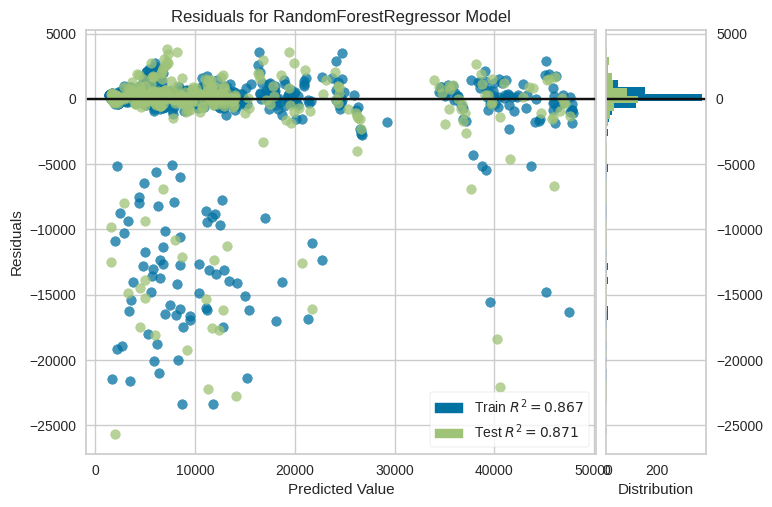

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [18]:
plot_model(tuned_rf, plot='residuals') 

# 다양한 모델 결과 확인
evaluate_model(tuned_rf)

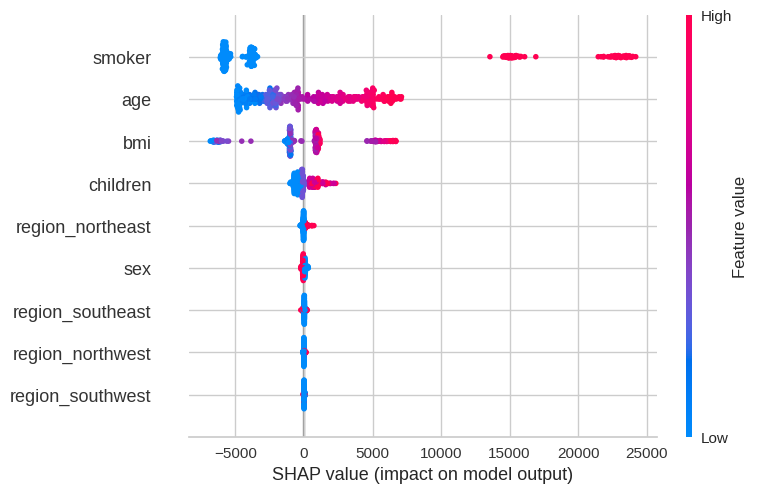

In [19]:
# interpret summary model
interpret_model(tuned_rf, plot = 'summary')

In [20]:
test_result = predict_model(tuned_rf, data= df_test)
test_result.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1772.6787,19928523.5016,4464.1375,0.8538,0.3595,0.1345


,age,sex,bmi,children,smoker,region,expenses,prediction_label
0,56,female,39.799999,0,no,southeast,11090.719727,11693.362456
1,27,male,42.099998,0,yes,southeast,39611.761719,37475.810519
2,60,female,36.000000,0,no,northeast,13228.849609,12905.301386
3,30,female,32.400002,1,no,southwest,4149.740234,4613.938587
4,28,male,36.400002,1,yes,southwest,51194.558594,37012.046105


In [23]:
# 모델 저장
save_model(reg1_best, 'my_first_pipeline')

# 모델 불러오기
loaded_best_pipeline = load_model('my_first_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['age', 'bmi', 'children'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['sex', 'smoker', 'region'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['sex', 'smoker...
                                                                         'data_type': dtype('O'),
                                                                         'mapping': no     0
yes    1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['region'],
                                    transformer=OneHotEncoder(cols=['region'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('trained_model',
                 [GradientBoostingRegressor(random_state=42),
                  RandomForestRegressor(n_jobs=-1, random_state=42),
                  ExtraTreesRegressor(n_jobs=-1, random_state=42)])])

 PyCaret setup 함수의 주요 파라미터
 
data|	모델링할 데이터셋

target|	예측하려는 타겟 변수

session_id|	재현 가능한 결과를 얻기 위한 임의의 시드 값

train_size|	훈련 데이터셋의 비율

normalize|	수치형 변수 정규화 여부 (예: 'zscore', 'minmax' 등)

transformation|	수치형 변수 및 목표 변수를 정규 분포에 가깝게 변환할지 여부 (예: True, False)

categorical_imputation|	범주형 변수의 결측값을 처리할 방식 (예: 'constant', 'mode')

numeric_imputation|	수치형 변수의 결측값을 처리할 방식 (예: 'mean', 'median')

remove_multicollinearity|	다중공선성을 제거할지 여부

multicollinearity_threshold|	다중공선성을 판단할 상관계수 임계값
